In [8]:
from sklearn.cluster import MiniBatchKMeans


In [3]:
import xarray as xr
import rioxarray as rxr
from rioxarray.merge import merge_datasets
import numpy as np
import dask
import pyproj
from rasterio.enums import Resampling
from shapely.geometry import box, mapping
from dask.distributed import Client
from dask import delayed

import os
import requests
from tqdm import tqdm
import dask.array as da

import pystac_client
import planetary_computer
from dask.diagnostics import ProgressBar

from dask.distributed import Client

# Start the Dask client
client = Client(memory_limit='8GB')  # Adjust the memory limit based on your system's capacity

# Print the dashboard link
print(client.dashboard_link)

def retrieve_stac_items_bbox(url, collection, bbox, datetime, max_items=10, pc_flag=False, max_cloud_cover=2): 
    """
    This function retrieves the latest STAC items from a STAC API, filtered by cloud cover.
    
    Parameters
    ----------
    url : str
        The STAC API URL
    collection : str
        Collection ID to search in the STAC API
    bbox : list or tuple
        A tuple or list with coordinates of the target area for API search in the format (min x, min y, max x, max y)
    datetime : str
        ISO-8601 formatted date range, e.g., "2020-01-01/2020-12-31".
    pc_flag : boolean
        A boolean flag to specify whether the STAC API is Microsoft's planetary computer API. Default is set to False.
    max_items : integer
        Maximum number of items to retrieve from the STAC API. Default is 10.
    max_cloud_cover : float
        Maximum allowed cloud cover percentage for filtering. Default is 2%.

    Returns
    -------
    items : Generator
        The STAC item collection matching the query parameters.
    """
    if pc_flag:
        modifier = planetary_computer.sign_inplace
    else:
        modifier = None
        
    catalog = pystac_client.Client.open(
        url=url,
        modifier=modifier,
    )

    # Query for items, including the cloud cover filter
    search_results = catalog.search(
        collections=[collection],
        bbox=bbox,
        datetime=datetime,  # ISO-8601 formatted date range
        query={"eo:cloud_cover": {"lt": max_cloud_cover}},  # Cloud cover filter
        sortby=["-properties.datetime"],
        max_items=max_items
    )
    items = search_results.item_collection()

    return items

# Define parameters for Charlottesville, Virginia (1-degree square around the city center)
url = "https://planetarycomputer.microsoft.com/api/stac/v1"
collection = "landsat-c2-l2"

bbox = [-79.5, 37.9, -78.5, 38.9]  # 1-degree square bounding box around Charlottesville
bbox_geometry = mapping(box(*bbox))
time_range = "2020-01-01/2020-12-31"

items = retrieve_stac_items_bbox(
    url=url,
    collection=collection,
    bbox=bbox,
    datetime=time_range,  # Pass the time range directly
    max_items=1000,  # Retrieve up to 10 images
    pc_flag=True  # Use Planetary Computer API
)

def gen_stac_asset_urls(items, asset):
    """
    This function receives an items collection returned by a STAC API, and returns
    the urls of the requested `asset` in a list. 

    Inputs:
        items : json collection
            A STAC items collection returned by STAC API
        asset : string
            Name of an asset present in the `items` collection

    Returns:
        urls : list
            List of all usls related to the `asset`
            
    """

    urls = []
    for item in items:
        urls.append(item.assets[asset].href)
    
    return urls

red_urls = gen_stac_asset_urls(items, "red")
green_urls = gen_stac_asset_urls(items, "green")
blue_urls = gen_stac_asset_urls(items, "blue")

def open_rasters_with_dask(urls):
    return [rxr.open_rasterio(url, lock=False, chunks={'x': 512, 'y': 512}).to_dataset(name=url.split('/')[-1]) for url in urls]

with ProgressBar():
    red_datasets = open_rasters_with_dask(red_urls)
    green_datasets = open_rasters_with_dask(green_urls)
    blue_datasets = open_rasters_with_dask(blue_urls)

def merge_in_batches(datasets, batch_size=5):
    merged_result = None
    for i in range(0, len(datasets), batch_size):
        batch = datasets[i:i + batch_size]
        batch_merged = xr.merge(batch, compat = 'override')  # Merge the current batch
        if merged_result is None:
            merged_result = batch_merged
        else:
            merged_result = xr.merge([merged_result, batch_merged], compat='override')  # Merge with previous result
    return merged_result

def dask_merge_datasets(datasets):
    # Use delayed to merge datasets in batches
    delayed_batches = merge_in_batches(datasets)
    
    # Convert merged dataset to Dask array
    # We chunk the merged dataset after the delayed operations
    dask_array = delayed_batches.chunk({'x': 2048, 'y': 2048})  # Ensure chunking is efficient
    
    # Compute the result in parallel once all tasks are delayed
    result = dask.compute(dask_array)
    return result[0]

with ProgressBar():
    mosaic_red = dask_merge_datasets(red_datasets)
    mosaic_blue = dask_merge_datasets(blue_datasets)
    mosaic_green = dask_merge_datasets(green_datasets)

def dask_clip(dask_array, bbox_geometry, crs=4326):
    """
    Clip a Dask array lazily to a given bounding box using RioClip.
    
    Parameters
    ----------
    dask_array : xarray.DataArray or dask.array
        The Dask array to be clipped.
    bbox_geometry : dict
        The geometry for clipping (GeoJSON format).
    crs : int, optional
        The coordinate reference system (CRS) for the bounding box, default is 4326.
        
    Returns
    -------
    clipped : xarray.DataArray
        The clipped Dask array.
    """
    return dask_array.rio.clip([bbox_geometry], crs=crs)

with ProgressBar():
    mosaic_red = dask_clip(mosaic_red, bbox_geometry)
    mosaic_blue = dask_clip(mosaic_blue, bbox_geometry)
    mosaic_green = dask_clip(mosaic_green, bbox_geometry)

with ProgressBar():
    mosaic_red[list(mosaic_red.data_vars)[0]].rio.to_raster("red_clipped.tif")
    mosaic_blue[list(mosaic_blue.data_vars)[0]].rio.to_raster("blue_clipped.tif")
    mosaic_green[list(mosaic_green.data_vars)[0]].rio.to_raster("green_clipped.tif")

final_mosaic = xr.merge([mosaic_red, mosaic_green, mosaic_blue], compat='override')
final_mosaic = final_mosaic.squeeze()
final_mosaic.rio.to_raster('final_mosaic.tif')

/home/monyy3m/miniconda3/envs/geospatial-clustering/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44727 instead
  warnings.warn(


http://127.0.0.1:44727/status


/home/monyy3m/miniconda3/envs/geospatial-clustering/lib/python3.9/site-packages/dask/array/core.py:4839: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/home/monyy3m/miniconda3/envs/geospatial-clustering/lib/python3.9/site-packages/dask/array/core.py:4839: PerformanceWarning: Increasing number of chunks by factor of 16
  result = blockwise(
/home/monyy3m/miniconda3/envs/geospatial-clustering/lib/python3.9/site-packages/dask/array/core.py:4839: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/home/monyy3m/miniconda3/envs/geospatial-clustering/lib/python3.9/site-packages/dask/array/core.py:4839: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/home/monyy3m/miniconda3/envs/geospatial-clustering/lib/python3.9/site-packages/dask/array/core.py:4839: PerformanceWarning: Increasing number of chunks by factor of 14
  result = blockwise(
/home/monyy3m/miniconda3/envs/geospatial-clus

In [6]:
print("Available variables:", list(final_mosaic.data_vars))


Available variables: ['A1DjMnpdcpBRnOHgP%2BRFLrSWoPkBPYwIr9ko%3D']


In [9]:
# Bridge between the codes:
# Convert the final mosaic to a format suitable for clustering
stacked_array = final_mosaic['A1DjMnpdcpBRnOHgP%2BRFLrSWoPkBPYwIr9ko%3D'].values

# Reshape the array if needed for clustering
valid_mask = stacked_array > 0
valid_data = stacked_array[valid_mask]

# Apply MiniBatch KMeans Clustering
n_clusters = 10
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=1024)
kmeans.fit(valid_data.reshape(-1, 1))

MiniBatchKMeans(n_clusters=10, random_state=42)

/home/monyy3m/miniconda3/envs/geospatial-clustering/lib/python3.9/site-packages/pystac_client/item_search.py:836: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Selected Item: LC08_L2SP_033033_20231227_02_T1


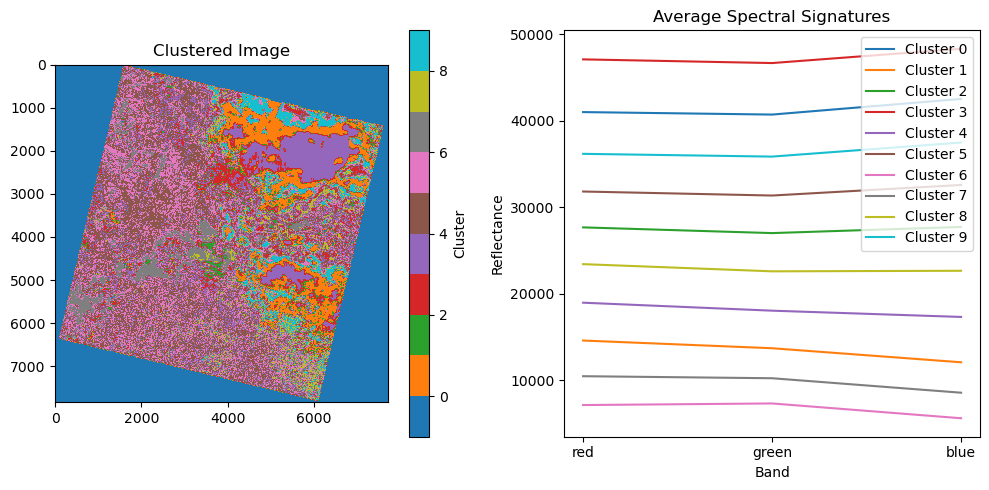

/home/monyy3m/miniconda3/envs/geospatial-clustering/lib/python3.9/site-packages/pystac_client/item_search.py:836: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Selected Item: LC08_L2SP_033033_20231227_02_T1


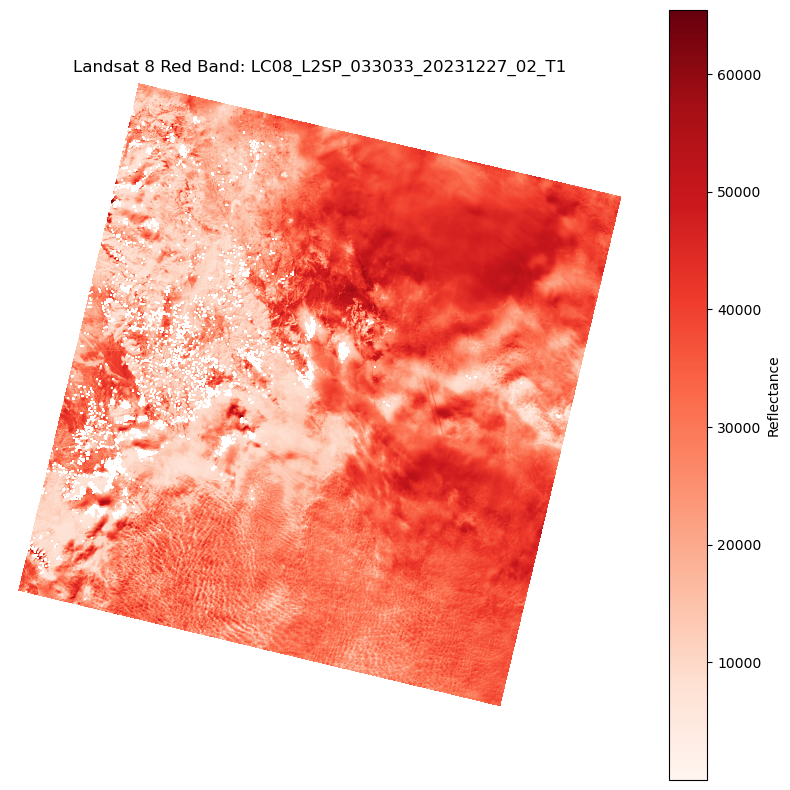

In [12]:
import planetary_computer as pc
import pystac_client
import rioxarray
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans

# Step 1: Search and Load a Landsat Image from MPC
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# Define a sample AOI and time range
search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=[-105.0, 39.5, -104.5, 40.0],  # Example: Bounding Box around Denver, CO
    datetime="2023-01-01/2023-12-31",
    limit=1
)

item = next(search.get_items())
print("Selected Item:", item.id)

# Sign asset HREFs
asset_hrefs = {key: pc.sign(asset.href) for key, asset in item.assets.items()}

# Open relevant bands (e.g., B2, B3, B4 for RGB)
bands = ["red", "green", "blue"]  # Blue, Green, Red
arrays = [
    rioxarray.open_rasterio(asset_hrefs[band]).squeeze() for band in bands
]

# Stack bands into a single array
stacked_array = np.stack([arr.values for arr in arrays], axis=-1)

# Mask invalid values (e.g., clouds, fill values)
valid_mask = np.all(stacked_array > 0, axis=-1)
valid_data = stacked_array[valid_mask]

# Step 2: Apply MiniBatch KMeans Clustering
n_clusters = 10
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=1024)
kmeans.fit(valid_data)

# Assign clusters to the full image
cluster_labels = -1 * np.ones(stacked_array.shape[:2], dtype=int)
cluster_labels[valid_mask] = kmeans.predict(valid_data)

# Step 3: Compute Average Spectral Signatures
cluster_means = np.zeros((n_clusters, stacked_array.shape[-1]))
for cluster in range(n_clusters):
    cluster_data = valid_data[kmeans.labels_ == cluster]
    cluster_means[cluster] = cluster_data.mean(axis=0)

# Step 4: Visualization
# (a) Plot the clustered image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Clustered Image")
plt.imshow(cluster_labels, cmap="tab10")
plt.colorbar(label="Cluster")

# (b) Plot average spectral signatures
plt.subplot(1, 2, 2)
plt.title("Average Spectral Signatures")
for i, mean in enumerate(cluster_means):
    plt.plot(mean, label=f"Cluster {i}")
plt.xticks(range(len(bands)), bands)
plt.xlabel("Band")
plt.ylabel("Reflectance")
plt.legend()
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import rioxarray

# Step 1: Search and Load a Landsat Image from MPC
from pystac_client import Client

catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# Define a sample AOI and time range
search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=[-105.0, 39.5, -104.5, 40.0],  # Example: Bounding Box around Denver, CO
    datetime="2023-01-01/2023-12-31",
    limit=1
)

item = next(search.get_items())
print("Selected Item:", item.id)

# Step 2: Access the COG URL for the red band
assets = item.assets
red_url = assets["red"].href

# Authenticate URL (if needed)
import planetary_computer as pc

red_url = pc.sign(red_url)

# Step 3: Load the red band using rioxarray
red = rioxarray.open_rasterio(red_url, masked=True)

# Step 4: Plot the red band
plt.figure(figsize=(10, 10))
plt.imshow(red.squeeze(), cmap="Reds")  # Use .squeeze() to remove the single-band dimension
plt.colorbar(label="Reflectance")
plt.title(f"Landsat 8 Red Band: {item.id}")
plt.axis("off")
plt.show()